# MRS spectral quality
- SNR and peak linewidth dependencies
- Origins of the 5ppm artefact
- Analysis of data rejection

In [1]:
# %% init
from IPython import get_ipython
import matplotlib.pylab as plt
import matplotlib.colors as coco
from matplotlib import dates
from datetime import datetime
import mrs.reco as reco
import mrs.log as log
import mrs.paths as default_paths
import numpy as np
import pickle
get_ipython().magic("clear")
plt.close("all")

get_ipython().magic("matplotlib notebook")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

import os
os.chdir("/home/tangir/crmbm/python/shrimp")

(DEBUG) Loaded backend nbAgg version unknown.


## Open reconstructed data database file and print available datasets


In [2]:
with open(default_paths.DEFAULT_RECO_DATA_DB_FILE, 'rb') as f:
    [pkl_data_dict] = pickle.load(f)

patient_name_keys = list(pkl_data_dict.keys())
for pnk in patient_name_keys:
    # avoid DICOMs (no patient names!)
    if(pnk is not None):
        dataset_keys = list(pkl_data_dict[pnk].keys())
        print("> Patient name = " + pnk)
        for dk in dataset_keys:
            print(">> Dataset name = " + dk)
        

> Patient name = 291_VS_MOELLE_SPECTRO_P1
>> Dataset name = #0 STEAM #1 (concatenated)
>> Dataset name = #0 sLASER #1 (concatenated)
>> Dataset name = #0 sLASER #2
> Patient name = 296_YM_P1_BRAINMOELLE
>> Dataset name = #0 comparing DCM steam
>> Dataset name = #1 comparing DCM sLASER R:N=20:1
>> Dataset name = #2 comparing TWIX steam
>> Dataset name = #3 comparing TWIX sLASER R:N=20:1
>> Dataset name = #0 brain - sLASER R:N=25:1 (TWIX)
>> Dataset name = #1 brain - sLASER R:N=5:5 (TWIX)
>> Dataset name = #0 brain - FID modulus test - sLASER no VAPOR + FID modulus process
>> Dataset name = #0 brain - FID modulus test - sLASER no VAPOR + conventionnal process
> Patient name = 300_PM_P1_MOELLE
>> Dataset name = #0 sLASER R:N=25:1 (DICOM)
>> Dataset name = #1 sLASER R:N=25:1 trig (DICOM)
> Patient name = 294_PM_P1_MOELLE
>> Dataset name = #2 sLASER R:N=25:1 (TWIX)
>> Dataset name = #3 sLASER R:N=25:1 trig (TWIX)
> Patient name = 304_KA_P1_MOELLE
>> Dataset name = #0 crappy
> Patient name =

## For each dataset, extract parameters:
SNR, linewidth, weight, height, Vref, TE, shims, and more... 

In [3]:
data_reco = {"snr": [], 
             "lw": [], 
             "weight": [], 
             "height": [], 
             "sex": [], 
             "vref": [], 
             "te": [], 
             "tr": [], 
             "voxel_pos": [],
             "voxel_size": [], 
             "voxel_volume": [], 
             "seq" : [], 
             "r": [], 
             "n": [], 
             "shims": [], 
             "patient_name": [], 
             "dataset_name": [], 
             "is_dicom": [], 
             "na_pre_rej": [], 
             "na_post_rej": [],
             "artefact_level": [],
             "n_coil_channels": []}

patient_name_keys = list(pkl_data_dict.keys())
for pnk in patient_name_keys:
    # avoid DICOMs (no patient names!)
    if(pnk is not None):
        dataset_keys = list(pkl_data_dict[pnk].keys())
        print("> Patient name = " + pnk)
        for dk in dataset_keys:
            print(">> Dataset name = " + dk)
            p = pkl_data_dict[pnk][dk]["pipeline"]
            s = pkl_data_dict[pnk][dk]["data"]
            
            data_reco["patient_name"].append(pnk)
            data_reco["dataset_name"].append(dk)
            
            # get SNR/LWs from pipeline
            if(p.analyze_enable):
                data_labels = list(p._analyze_results_dict.keys())
                job_labels = list(p._analyze_results_dict[dk]["snr"].keys())
                last_job_key = job_labels[-1]
                data_reco["snr"].append(p._analyze_results_dict[dk]["snr"][last_job_key])
                data_reco["lw"].append(p._analyze_results_dict[dk]["lw"][last_job_key])
            else:
                data_reco["snr"].append(None)
                data_reco["lw"].append(None)
                
            # get patient stuff
            data_reco["weight"].append(s.patient_weight)
            data_reco["height"].append(s.patient_height)
            data_reco["sex"].append(s.patient_sex)
            
            # get coil stuff
            data_reco["n_coil_channels"].append(p.data_coil_nChannels)
            
            # get sequence stuff
            data_reco["shims"].append(s.shims)
            data_reco["seq"].append(s.sequence.name)
            data_reco["vref"].append(s.vref)
            data_reco["te"].append(s.te)
            data_reco["tr"].append(s.tr)
            
            # voxel stuff
            data_reco["voxel_pos"].append(s.to_scanner(0, 0, 0))
            data_reco["voxel_volume"].append(s.voxel_volume())
            data_reco["voxel_size"].append(s.voxel_size)
            
            # data processing stuff
            data_reco["is_dicom"].append(s.is_dicom)
            data_reco["na_pre_rej"].append(s.na_pre_data_rejection)
            data_reco["na_post_rej"].append(s.na_post_data_rejection)
            
            # artefact around 5ppm
            snr_5ppm, _, _ = s.analyze_snr_1d([4.9, 7], [-1, 0], True)
            data_reco["artefact_level"].append(snr_5ppm)
            
            # if sLASER sequence
            if(s.sequence.name == "eja_svs_slaser"):
                data_reco["r"].append(s.sequence.pulse_rfc_r)
                data_reco["n"].append(s.sequence.pulse_rfc_n)
            else:
                data_reco["r"].append(None)
                data_reco["n"].append(None)  

# convert to numpy
for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k])
    
# fix numpy type
data_reco["na_pre_rej"] = data_reco["na_pre_rej"].astype('float')
data_reco["na_post_rej"] = data_reco["na_post_rej"].astype('float')
                
data_reco["bmi"] = data_reco["weight"] / data_reco["height"]**2

(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 STEAM #1 (concatenated)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.22ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 STEAM #1 (concatenated)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.16E+03, N = 3.16E+02, SNR = 22.64!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER #1 (concatenated)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.09ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!


> Patient name = 291_VS_MOELLE_SPECTRO_P1
>> Dataset name = #0 STEAM #1 (concatenated)
>> Dataset name = #0 sLASER #1 (concatenated)


(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER #1 (concatenated)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.64E+04, N = 3.35E+02, SNR = 108.77!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER #2]...


>> Dataset name = #0 sLASER #2


(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.48ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER #2] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.67E+04, N = 9.71E+02, SNR = 37.82!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 comparing DCM steam]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.19ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 comparing DCM steam] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.08E+11, N = 1.39E+10, SNR = 14.93!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 comparing DCM sLASER R:N=20:1]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(D

> Patient name = 296_YM_P1_BRAINMOELLE
>> Dataset name = #0 comparing DCM steam
>> Dataset name = #1 comparing DCM sLASER R:N=20:1
>> Dataset name = #2 comparing TWIX steam
>> Dataset name = #3 comparing TWIX sLASER R:N=20:1


(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 comparing TWIX sLASER R:N=20:1] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.95E+03, N = 2.24E+02, SNR = 26.51!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - sLASER R:N=25:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.93ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - sLASER R:N=25:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.43E+03, N = 1.75E+02, SNR = 25.28!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 brain - sLASER R:N=5:5 (TWIX)]...


>> Dataset name = #0 brain - sLASER R:N=25:1 (TWIX)
>> Dataset name = #1 brain - sLASER R:N=5:5 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 brain - sLASER R:N=5:5 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.06E+03, N = 2.42E+02, SNR = 29.18!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - FID modulus test - sLASER no VAPOR + FID modulus process]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.95ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - FID modulus test - sLASER no VAPOR + FID modulus process] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 8.86E-05, N = 6.05E-06, SNR = 14.64!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 br

>> Dataset name = #0 brain - FID modulus test - sLASER no VAPOR + FID modulus process
>> Dataset name = #0 brain - FID modulus test - sLASER no VAPOR + conventionnal process
> Patient name = 300_PM_P1_MOELLE
>> Dataset name = #0 sLASER R:N=25:1 (DICOM)
>> Dataset name = #1 sLASER R:N=25:1 trig (DICOM)
> Patient name = 294_PM_P1_MOELLE
>> Dataset name = #2 sLASER R:N=25:1 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER R:N=25:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.57E+03, N = 2.26E+02, SNR = 29.05!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER R:N=25:1 trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 sLASER R:N=25:1 trig (TWIX)] coming...


>> Dataset name = #3 sLASER R:N=25:1 trig (TWIX)


(INFO)  MRSData2.analyze_snr_1d: S = 6.11E+03, N = 2.29E+02, SNR = 26.68!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 crappy]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 crappy] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.44E+11, N = 1.34E+10, SNR = 18.26!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 cardiac trig]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.94ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 cardiac trig] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.54E+11, N = 2.02E+10, SNR = 17.58!
(DEBUG) MRSData2.ana

> Patient name = 304_KA_P1_MOELLE
>> Dataset name = #0 crappy
> Patient name = 307_AP_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 cardiac trig
>> Dataset name = #1 sLASER 20:1 resp trig
>> Dataset name = #2 sLASER 20:1 no trig
>> Dataset name = #3 sLASER 10:1 repos. + resp trig


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 10:1 repos. + resp trig]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 sLASER 10:1 repos. + resp trig] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.69E+11, N = 2.41E+10, SNR = 27.75!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#4 sLASER 20:1 cardiac trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.60ppm!


>> Dataset name = #4 sLASER 20:1 cardiac trig (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#4 sLASER 20:1 cardiac trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.81E+03, N = 3.88E+02, SNR = 14.97!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#5 sLASER 20:1 resp trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#5 sLASER 20:1 resp trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.87E+04, N = 4.60E+02, SNR = 40.53!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#6 sLASER 20:1 no trig (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 6.65ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimati

>> Dataset name = #5 sLASER 20:1 resp trig (TWIX)
>> Dataset name = #6 sLASER 20:1 no trig (TWIX)
>> Dataset name = #7 sLASER 10:1 repos. + resp trig (TWIX)
> Patient name = 308_RS_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 resp trig
>> Dataset name = #1 sLASER 20:1 resp trig (TWIX)
>> Dataset name = #0 brain - sLASER 20:1 resp trig (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - sLASER 20:1 resp trig (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.20E+03, N = 2.19E+02, SNR = 28.26!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 SC]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.08ppm!


> Patient name = 310_MG_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 SC


(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 SC] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.10E+04, N = 7.42E+02, SNR = 14.76!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 (DICOM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.93E+11, N = 1.86E+10, SNR = 31.93!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER 20:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INF

> Patient name = 311_SL_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (DICOM)
>> Dataset name = #1 sLASER 20:1 (TWIX)
> Patient name = 313_FT_P1_MOELLE
>> Dataset name = #0 sLASER 20:1
> Patient name = 314_YT_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 20:1 (DICOM)
>> Dataset name = #2 sLASER 5:5 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 5:5 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.39ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 5:5 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.34E+04, N = 6.55E+02, SNR = 20.50!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 5:5 (DICOM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.42ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 sLASER 5:5 (DICOM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 8.38E+11, N = 4.42E+10, SNR = 18.96!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (TWIX)]...
(DEBUG

>> Dataset name = #3 sLASER 5:5 (DICOM)
> Patient name = 316_AP_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 5:5 (TWIX)
>> Dataset name = #2 sLASER 20:1 (DICOM)
>> Dataset name = #3 sLASER 5:5 (DICOM)
> Patient name = 319_FC_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 10:2 (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER 10:2 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.08ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 10:2 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.35E+04, N = 1.78E+03, SNR = 7.59!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (TWIX)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.34E+03, N = 3.19E+02, SNR = 13.58!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 (TWIX)]...
(DEBU

> Patient name = 328_AF_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
> Patient name = 329_PI_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 10:2 (TWIX)
> Patient name = 333_SC_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (DCM)
>> Dataset name = #1 sLASER 20:1 IR (DCM)
> Patient name = 336_NB_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 (TWIX)
>> Dataset name = #1 sLASER 20:1 IR (TWIX)


(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.92ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER 20:1 IR (TWIX)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.41E-05, N = 1.62E-06, SNR = 14.85!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 20:1 (DCM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 20:1 (DCM)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.99E+03, N = 1.79E+02, SNR = 22.33!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 20:1 IR (DCM)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DE

>> Dataset name = #2 sLASER 20:1 (DCM)
>> Dataset name = #3 sLASER 20:1 IR (DCM)
> Patient name = 338_RO_P1_MOELLE
>> Dataset name = #0 sLASER 20:1 WS (TWIX)
>> Dataset name = #0 sLASER 20:1 noWS (TWIX)
> Patient name = 300_PM_P2_MOELLE
>> Dataset name = #0 STEAM IR (REF with OVS)
>> Dataset name = #1 STEAM IR (REF without OVS)


(INFO)  MRSData2.analyze_snr_1d: S = 3.14E+03, N = 1.88E+02, SNR = 16.72!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#2 sLASER 20:1 (REF with OVS)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.18ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#2 sLASER 20:1 (REF with OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 4.00E+03, N = 1.90E+02, SNR = 21.10!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#3 sLASER 20:1 (REF without OVS)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.09ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#3 sLASER 20:1 (REF without OVS)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 3.49E+0

>> Dataset name = #2 sLASER 20:1 (REF with OVS)
>> Dataset name = #3 sLASER 20:1 (REF without OVS)
>> Dataset name = #4 sLASER IR 5:5 (REF with OVS)
>> Dataset name = #5 sLASER IR 5:5 (REF without OVS)
> Patient name = 349_AP_P1_MOELLE
>> Dataset name = #0 sLASER 10:2 (REF with OVS)
>> Dataset name = #1 sLASER 10:2 (REF without OVS)
> Patient name = 355_ST_P1_MOELLE
>> Dataset name = #0 sLASER TE=52ms


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER TE=52ms]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 4.94ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER TE=52ms] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.75E+03, N = 5.23E+02, SNR = 10.99!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 1st try (30-40Hz water LW)]...
(DEBUG) MRSData2.analyze_snr_1d: going to analyze the MAGNITUDE spectrum...
(DEBUG) MRSData2.analyze_snr_1d: by measuring the intensity at 5.11ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -1.00 to 0.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 1st try (30-40Hz water LW)] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.87E+05, N = 1.56E+03, SNR = 120.28!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 2nd try (25Hz wate

> Patient name = 304_KA_P2_MOELLE
>> Dataset name = #0 1st try (30-40Hz water LW)
>> Dataset name = #1 2nd try (25Hz water LW)
> Patient name = 347_RE_P1_MOELLE
>> Dataset name = #0 sLASER 10:2 IR TE=40ms (TWIX)
>> Dataset name = #1 sLASER 10:2 IR TE=30ms (TWIX)
>> Dataset name = #2 sLASER 10:2 TE=30ms (TWIX)


## Excluding some datasets
- datasets for which no SNR is available (== None)
- datasets relative to inversion-recovery ("IR" in dataset label)
- datasets relative to FID modulus tests ("FID modulus" in dataset label)
- datasets from dicom files (need to check if I am removing patients when doing that, and which patients)
- separate bain and spinal cord datasets (number of coil channels) 

In [4]:
# filter out nones
data_mask_snr_not_nones = (data_reco["snr"] != np.array(None))
for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][data_mask_snr_not_nones])
    
# filter out IR acquisitions
data_mask_not_IR = ("IR" not in data_reco["dataset_name"])
for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][data_mask_not_IR])
    
# filter out FIDmod acquisitions
data_mask_not_FIDmod = ("FID modulus" not in data_reco["dataset_name"])
for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][data_mask_not_FIDmod])

# keep a copy for later
data_reco_with_dicoms = data_reco.copy()
    
# filter out dicoms
data_mask_not_dicoms = np.logical_not(data_reco["is_dicom"])
data_patient_not_dicoms = data_reco["patient_name"][data_mask_not_dicoms]
if(len(np.unique(data_patient_not_dicoms)) != len(np.unique(data_reco["patient_name"]))):
    # some patients had only dicoms ? which patients?
    problematic_patients = [p for p in np.unique(data_reco["patient_name"]) if p not in np.unique(data_patient_not_dicoms)]
    print("All data from the following patient names has been removed from the analysis because the acquired datasets were in DICOM format. You should check this out carefully...")
    print(problematic_patients)

for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][data_mask_not_dicoms])

# separate brain data from SC data
data_mask_32ch = (data_reco["n_coil_channels"] == 32)

data_reco_brain = {}
for k in list(data_reco.keys()):
    data_reco_brain[k]= np.array(data_reco[k][data_mask_32ch])
    
for k in list(data_reco.keys()):
    data_reco[k]= np.array(data_reco[k][np.logical_not(data_mask_32ch)])
    
# also exclude brain scans from twix and dicom SC data
data_mask_32ch = (data_reco_with_dicoms["n_coil_channels"] == 32)
for k in list(data_reco.keys()):
    data_reco_with_dicoms[k]= np.array(data_reco_with_dicoms[k][np.logical_not(data_mask_32ch)])

All data from the following patient names has been removed from the analysis because the acquired datasets were in DICOM format. You should check this out carefully...
['300_PM_P1_MOELLE', '304_KA_P1_MOELLE', '333_SC_P1_MOELLE']


## Plot the best and worst spectra
according to SNR

In [5]:
# finding best SNR spectrum in brain
i_snr_max = np.argmax(data_reco_brain["snr"])
pnk = data_reco_brain["patient_name"][i_snr_max]
dk = data_reco_brain["dataset_name"][i_snr_max]
s = pkl_data_dict[pnk][dk]["data"]
s._dt = 1 / 10000
s._f0 = 300
s.ppm0 = 4.7
s.display_spectrum_1d(1)
plt.title("Brain - Best SNR = %.2f (LW = %.2f)" % (data_reco_brain["snr"][i_snr_max], data_reco_brain["lw"][i_snr_max]))

# finding best SNR spectrum in sc
i_snr_max = np.argmax(data_reco["snr"])
pnk = data_reco["patient_name"][i_snr_max]
dk = data_reco["dataset_name"][i_snr_max]
s = pkl_data_dict[pnk][dk]["data"]
s._dt = 1 / 10000
s._f0 = 300
s.ppm0 = 4.7
s.display_spectrum_1d(2)
plt.title("SC - Best SNR = %.2f (LW = %.2f)" % (data_reco["snr"][i_snr_max], data_reco["lw"][i_snr_max]))

# finding best SNR spectrum in sc
i_snr_min = np.argmin(data_reco["snr"])
pnk = data_reco["patient_name"][i_snr_min]
dk = data_reco["dataset_name"][i_snr_min]
s = pkl_data_dict[pnk][dk]["data"]
s._dt = 1 / 10000
s._f0 = 300
s.ppm0 = 4.7
s.display_spectrum_1d(3)
plt.title("SC - Worst SNR = %.2f (LW = %.2f)" % (data_reco["snr"][i_snr_min], data_reco["lw"][i_snr_max]))


(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 brain - sLASER R:N=25:1 (TWIX)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 WS (TWIX)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 1st try (30-40Hz water LW)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'SC - Worst SNR = 3.24 (LW = 19.53)')

## Cohort: height vs. weight vs. BMI
to check cohort characteristics

In [6]:
cm = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots()
sc = ax.scatter(data_reco["weight"], data_reco["height"], c=data_reco["bmi"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Patient weight (kg)", fontsize=11)
ax.set_ylabel("Patient height (m)", fontsize=11)
ax.set_title("Patient height vs. weight vs. BMI")
ax.grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

print("Mean weight = %.2fkgs +/-%2.f " % (np.mean(data_reco["weight"]), np.std(data_reco["weight"])))
print("Mean height = %.2fm +/-%2.f " % (np.mean(data_reco["height"]), np.std(data_reco["height"])))
print("Mean BMI = %.2f +/-%2.f " % (np.mean(data_reco["bmi"]), np.std(data_reco["bmi"])))
sex_M = np.sum(data_reco["sex"] == "M")
sex_F = np.sum(data_reco["sex"] == "F")
print("Sex = M(%d) F(%d)" % (sex_M, sex_F))


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff24bed4580>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff24bed4580>
(DEBUG) Setting pcolormesh


Mean weight = 62.42kgs +/-13 
Mean height = 1.70m +/- 0 
Mean BMI = 21.28 +/- 2 
Sex = M(15) F(23)


## $B_1$ power (reference voltage) vs. BMI
reference RF voltage increases with BMI

In [7]:
cm = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots(1, 2)
sc = ax[0].scatter(data_reco["bmi"], data_reco["vref"], s=100, alpha=0.5)
ax[0].set_xlabel("Patient BMI", fontsize=11)
ax[0].set_ylabel("Reference voltage (V)", fontsize=11)
ax[0].set_title("Ref. voltage vs. BMI", fontsize=11)
ax[0].grid(True)

sc = ax[1].scatter(data_reco["weight"], data_reco["height"], c=data_reco["vref"], s=100, alpha=0.5, cmap=cm)
ax[1].set_xlabel("Patient weight (kg)", fontsize=11)
ax[1].set_ylabel("Patient height (m)", fontsize=11)
ax[1].set_title("Patient height vs. height vs. Ref. voltage", fontsize=11)
ax[1].grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff25856d0a0>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff25856d0a0>
(DEBUG) Setting pcolormesh


## Voxel position vs. BMI
Voxel position relative to magnet center increases with BMI

In [8]:
fig, ax = plt.subplots()
sc = ax.scatter(data_reco["bmi"], -data_reco["voxel_pos"][:, 1], s=100, alpha=0.5)
ax.set_xlabel("Patient BMI", fontsize=11)
ax.set_ylabel("- Voxel Y position rel. to MRI center", fontsize=11)
ax.set_title("Patient BMI vs. voxel Y position", fontsize=11)
ax.grid(True)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## SNR vs. LW vs. BMI
SNR is normalized by:
- voxel size
- number of averages (post-data-rejection)
- voxel position in Y

Therefore
- SNR values are divided by voxel volume and multiplied by a mean volume to get usual SNR values
- SNR values are divided by $\sqrt(NA)$ kept after data rejection and multiplied by $\sqrt(128)$
- SNR values are multiplied by $(1+\frac{y^2}{R^2})^{\frac{2}{3}}$ and multiplied by $(1+\frac{y_{mean}^2}{R^2})^{\frac{2}{3}}$

According to the Biot–Savart law (Jackson, 1975), cited in https://doi.org/10.1201/9781315107325, the distance relative to the RF loop surface coil impacts SNR with a $(1+\frac{y^2}{R^2})^{\frac{2}{3}}$ term. $y$ is the absolute distance between the voxel and the RF coil, $R$ is the coil radius. $y_{mean}$ is the average $y$ position over the whole group.

The problem is to evaluate this absolute distance to coil when I only know the voxel position relative to the magnet center... Let's take the lowest voxel position in the study group, probably for the thinnest subject and consider that we were 4cm away from the coil.

Ok, another problem is that we were using a multi-channel Rx spinal cord coil. What do I put for the radius? Assuing a 14cm radius coil... Big approximation.

In [9]:
# for each SNR measurement, normalize by voxel size and number of averages
# dicom data will be rejected

# init
data_reco["snr_norm"] = data_reco["snr"]
data_reco_brain["snr_norm"] = data_reco_brain["snr"]

# VOI normalization
mean_voxel_vol = np.mean(data_reco["voxel_volume"])
data_reco["snr_norm"] = data_reco["snr_norm"] / data_reco["voxel_volume"] * mean_voxel_vol
data_reco_brain["snr_norm"] = data_reco_brain["snr_norm"] / data_reco_brain["voxel_volume"] * mean_voxel_vol

# NA normalization
std_na = 128.0
data_reco["snr_norm"] = data_reco["snr_norm"] / np.sqrt(data_reco["na_post_rej"]) * np.sqrt(std_na)
data_reco_brain["snr_norm"] = data_reco_brain["snr_norm"] / np.sqrt(data_reco_brain["na_post_rej"]) * np.sqrt(std_na)

cm = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots()
sc = ax.scatter(data_reco["lw"], data_reco["snr_norm"], c=data_reco["bmi"], s=100, alpha=0.5, cmap=cm)
ax.scatter(data_reco_brain["lw"], data_reco_brain["snr_norm"], s=100, alpha=0.5, c='green')
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. LW vs. BMI (brain in green)")
ax.set_xlim([0, 60])
ax.grid(True)

plt.colorbar(sc)

# Y voxel position normalization
min_dist_voxel_coil_mm = 40.0  # mm
coil_radius_mm = 140.0 / 2  # mm 
# looking for minimum Y position
max_pos = np.max(data_reco["voxel_pos"][:, 1])
data_reco["abs_y_pos"] = -(data_reco["voxel_pos"][:, 1] - max_pos) + min_dist_voxel_coil_mm
mean_abs_y_pos = np.mean(data_reco["abs_y_pos"])
# normalization
data_reco["snr_norm_voxpos"] = data_reco["snr_norm"] * np.power(1 + np.power(data_reco["abs_y_pos"], 2) / np.power(coil_radius_mm, 2), 3/2)
data_reco["snr_norm_voxpos"] = data_reco["snr_norm_voxpos"] / np.power(1 + np.power(mean_abs_y_pos, 2) / np.power(coil_radius_mm, 2), 3/2)

fig, ax = plt.subplots()
sc = ax.scatter(data_reco["lw"], data_reco["snr_norm_voxpos"], c=data_reco["bmi"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI+Ypos norm. SNR vs. LW vs. BMI (SC only)")
ax.set_xlim([0, 60])
ax.grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff2581b9520>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff2581b9520>
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff2581222b0>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff2581222b0>
(DEBUG) Setting pcolormesh


## Artefact around 5 ppm
This artefact seems to increase when voxel size decreases in the X dimension. The sLASER sequence is a *semi-*LASER sequence, meaning that not all spatial dimensions are selected using adiabatic RF pulses (like in LASER). The X dimension is selected using a standard asymmetric RF sinc pulse whie Y and Z are selected using HSn Rf pulses.

I believe this artefact originates from badly localized signal in the X dimension because of the poor efficiency of the half sinc selection pulse in inhomogenous B1 situation (surface coil):
- This effect is increased when this bad pulse needs to select a small slice.
- Less clear but likely to happen, this effect is also increased when the VOI is far from the coil (Y position is high) and the B1 inhomogeneity gets even more crazy.
- Could be gradient non-linearities too?

In [10]:
# normalization of artefact SNR
data_reco_with_dicoms["artefact_level_norm"] = data_reco_with_dicoms["artefact_level"]

# VOI normalization
mean_voxel_vol = np.mean(data_reco_with_dicoms["voxel_volume"])
data_reco_with_dicoms["artefact_level_norm"] = data_reco_with_dicoms["artefact_level_norm"] / data_reco_with_dicoms["voxel_volume"] * mean_voxel_vol

# NA normalization
std_na = 128.0
data_reco_with_dicoms["artefact_level_norm"] = data_reco_with_dicoms["artefact_level_norm"] / np.sqrt(data_reco_with_dicoms["na_post_rej"]) * np.sqrt(std_na)

# Y voxel position normalization
# looking for minimum Y position
max_pos = np.max(data_reco_with_dicoms["voxel_pos"][:, 1])
data_reco_with_dicoms["abs_y_pos"] = -(data_reco_with_dicoms["voxel_pos"][:, 1] - max_pos) + min_dist_voxel_coil_mm
mean_abs_y_pos = np.mean(data_reco_with_dicoms["abs_y_pos"])
# normalization
data_reco_with_dicoms["artefact_level_norm_voxpos"] = data_reco_with_dicoms["artefact_level_norm"] * np.power(1 + np.power(data_reco_with_dicoms["abs_y_pos"], 2) / np.power(coil_radius_mm, 2), 3/2)
data_reco_with_dicoms["artefact_level_norm_voxpos"] = data_reco_with_dicoms["artefact_level_norm_voxpos"] / np.power(1 + np.power(mean_abs_y_pos, 2) / np.power(coil_radius_mm, 2), 3/2)

# find big artefact datasets
dataset_artefact_inds = np.where(data_reco_with_dicoms["artefact_level_norm"] > 200.0)[0]
for di in dataset_artefact_inds:
    pnk = data_reco_with_dicoms["patient_name"][di]
    dk = data_reco_with_dicoms["dataset_name"][di]
    s = pkl_data_dict[pnk][dk]["data"]
    s.display_spectrum_1d(100)

plt.show()


<ipython-input-10-001b19d09426>:22: RuntimeWarning: invalid value encountered in greater
  dataset_artefact_inds = np.where(data_reco_with_dicoms["artefact_level_norm"] > 200.0)[0]
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER #1 (concatenated)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 2nd try (25Hz water LW)]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


In [11]:
cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(data_reco_with_dicoms["voxel_size"][:, 0], data_reco_with_dicoms["artefact_level_norm_voxpos"], c=data_reco_with_dicoms["bmi"], s=10, alpha=0.5, cmap=cm)
ax.set_xlabel("X voxel size (mm)", fontsize=11)
ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
ax.set_yscale('log')
ax.set_title("Artefact level vs. X voxel size")
ax.grid(True)

plt.colorbar(sc0)

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff2580452e0>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff2580452e0>
(DEBUG) Setting pcolormesh


## Questions about scan-time, number of averages and data rejection
- How long shoud we scan vs. SNR vs. BMI (including all NAs)
- Data rejection rate vs. SNR/BMI/vref...
- Choosing SNR/LW threshold
- Percentage of exploitable scans/patients


<IPython.core.display.Javascript object>


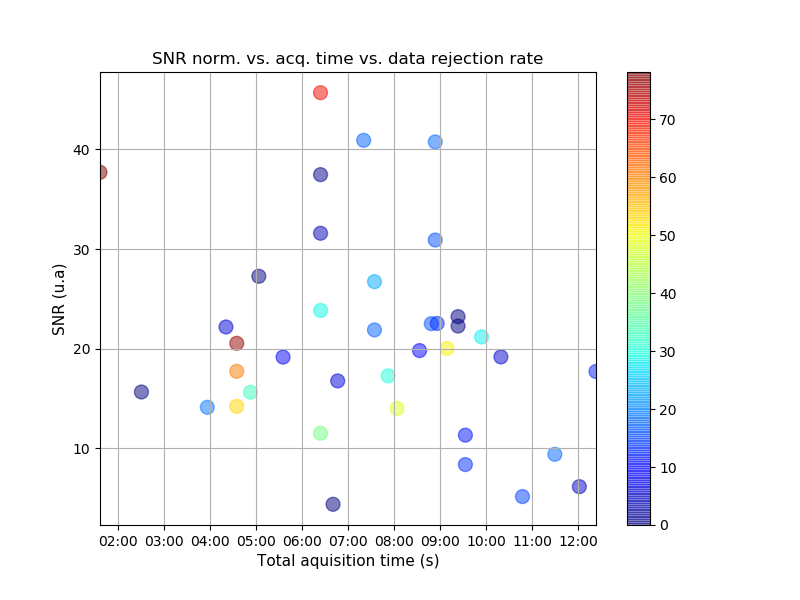

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff245957af0>
(DEBUG) Using auto colorbar locator on colorbar
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff245957af0>
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>


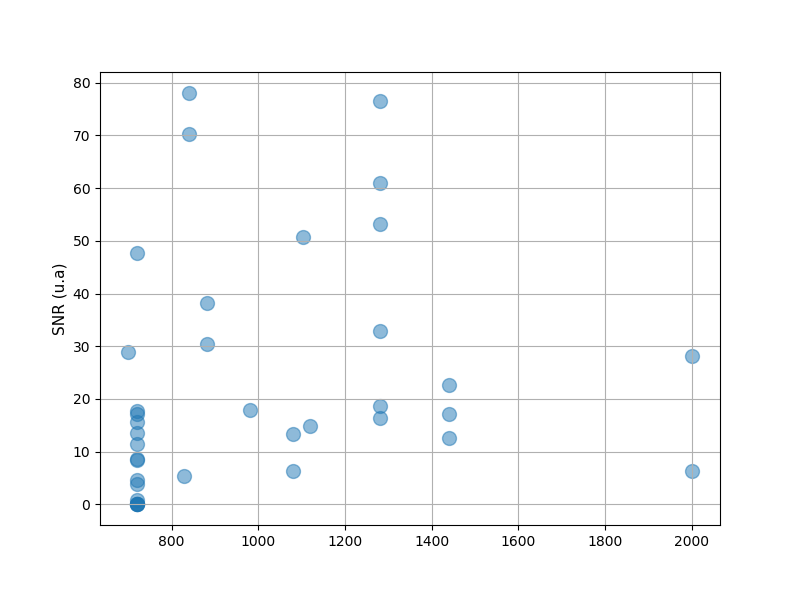

In [19]:
# calculate scan time knowing NA and TR, neglicting resp. trig
data_reco["acq_time"] = data_reco["tr"] * data_reco["na_pre_rej"]
data_reco["acq_time"] = [datetime.fromtimestamp(ts / 1000) for ts in data_reco["acq_time"]]

# calculating data rejection rate
data_reco["data_rej_prct"] = (data_reco["na_pre_rej"] - data_reco["na_post_rej"]) / data_reco["na_pre_rej"]  * 100.0

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(data_reco["acq_time"], data_reco["snr_norm_voxpos"], c=data_reco["data_rej_prct"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Total aquisition time (s)", fontsize=11)
ax.set_xticklabels(data_reco["acq_time"])
ax.xaxis.set_major_formatter(dates.DateFormatter("%M:%S"))
ax.set_xlim([min(data_reco["acq_time"]), max(data_reco["acq_time"])])
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("SNR norm. vs. acq. time vs. data rejection rate")
ax.grid(True)

plt.colorbar(sc0)

fig, ax = plt.subplots()
sc0 = ax.scatter(data_reco["voxel_volume"], data_reco["data_rej_prct"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("")
ax.grid(True)

2nd order shimming usefull ?

when to switch protocol ?
protocol gain ?